In [38]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import *
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile

In [39]:
2**14

16384

In [40]:
#first = Path('/DATA/WAMRI/salk/uri/Image_reconstruction_data/input').iterdir()
#list(first)

In [41]:
path = Path('/DATA/WAMRI/salk/uri/BPHO_Live_imaging/')
path_hr = path/'hr_images'
path_lr = path/'small-96'
test_items = list(Path('/DATA/WAMRI/salk/uri/Image_restoration_data/newimg/').iterdir())

path_hr.mkdir(exist_ok=True)

In [42]:
czi_files = list(path.glob('*.czi'))

In [43]:
shapes = []
shape_set = set()

axes = set()
imgs = 0
for fn in progress_bar(czi_files):
    czf = czifile.CziFile(fn)
    desc = dict()
    for c,val in zip(czf.axes, czf.shape):
        if c != 'H':
            desc[c] = val
            
    imgs += desc['C'] * desc['T'] * 3
    shapes.append(desc)
    axes.add(czf.axes)
    shape_set.add(tuple((desc[c] for c in 'BVCTZYX0')))
    czf.close()

shape_df = pd.DataFrame(shapes)

In [44]:
shape_df

,0,B,C,T,V,X,Y,Z
0,1,1,2,60,1,632,632,5
1,1,1,2,36,1,428,428,7
2,1,1,2,60,1,428,428,5
3,1,1,3,100,1,372,372,5
4,1,1,2,60,1,632,632,5
5,1,1,3,100,1,428,428,5
6,1,1,1,300,1,920,920,1
7,1,1,2,60,1,428,428,5
8,1,1,1,80,1,920,920,1
9,1,1,3,50,1,608,608,5


In [45]:
def save_img(dest_path, src_fn, c, t, z, data):
    save_name = dest_path/f'{fn.stem}_{c:03d}_{t:03d}_{t:03d}.tif'
    img = Image(data[None]).save(save_name)
    

def process_czi_file(fn, i):
    with czifile.CziFile(fn) as czf:
        data = tensor(czf.asarray().astype(float))
        data = data / data.max()
        
        if czf.axes == 'BVCTZYX0':
            for z in range(czf.shape[4]):
                for c in range(czf.shape[2]):
                    for t in range(1): # range(czf.shape[3]):
                        img_data = data[0,0,c,t,z,:,:,0]
                        save_img(path_hr, fn,c,t,z,img_data)
        elif czf.axes == 'VBHTCZYX0':
            for z in range(czf.shape[5]):
                for c in range(czf.shape[4]):
                    for t in range(1): #range(czf.shape[3]):
                        img_data = data[0,0,0,t,c,z,:,:,0]
                        save_img(path_hr, fn,c,t,z,img_data)

parallel(process_czi_file, czi_files)

In [46]:
hr_files = list(path_hr.glob('*.tif'))
len(hr_files)

133

In [47]:
il = ImageItemList.from_folder(path_hr, label_cls=ImageItemList)

In [48]:
il

ImageItemList (133 items)
[Image (3, 688, 688), Image (3, 428, 428), Image (3, 428, 428), Image (3, 688, 688), Image (3, 688, 688)]...
Path: /DATA/WAMRI/salk/uri/BPHO_Live_imaging/hr_images

In [49]:
def resize_one(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img,96,use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR)
    img.save(dest, quality=60)

In [21]:
parallel(resize_one, il.items)

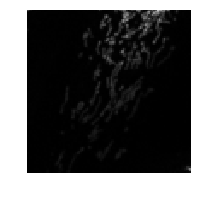

In [22]:
open_image(path_lr/il.items[0].relative_to(path_hr)).show()

In [23]:
#bs,size=4,512
#bs,size=16,256
bs,size=32,160
arch = models.resnet34

src =  (ImageItemList.from_folder(path_lr, label_cls=ImageItemList)
       .random_split_by_pct(0.1, seed=42))
data = (src.label_from_func(lambda x: path_hr/x.name)
       .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
       .add_test(test_items, label=test_items[0])
       .databunch(bs=bs)) #.normalize(imagenet_stats, do_y=True))

data.c = 3

In [24]:
trn,val,tst = data.train_ds,data.valid_ds, data.test_ds

In [30]:
data.train_ds[0][0].shape

torch.Size([3, 160, 160])

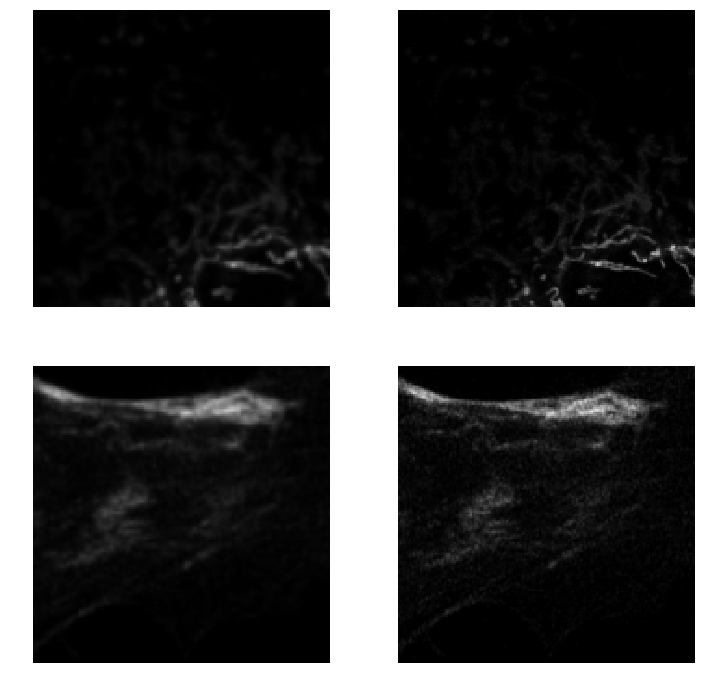

In [25]:
show_multi(lambda i,j: val[i][j], 2, 2, figsize=(12,12))

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).cuda().expand(1,3,3,3)/6

base_loss = F.mse_loss

In [31]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['L1      ','edge    '] + [f'feat_{i}  ' for i in range(len(layer_ids))]
        
    def make_feature(self, bs, o, clone=False):
        feat = o.view(bs, -1)
        return feat.clone() if clone else feat
    
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [self.make_feature(x.shape[0], o, clone) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        px_loss   = base_loss(input,target)
        edge_loss = base_loss(F.conv2d(target, k), F.conv2d(input, k))
        self.feat_losses = [px_loss,edge_loss]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [32]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [33]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [34]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,5,5])

In [35]:
def get_preds():
    x,y=learn.data.one_batch(DatasetType.Valid, True,True)
    #preds = data.denorm(learn.pred_batch(DatasetType.Valid).detach())
    preds = learn.pred_batch(DatasetType.Valid).detach()
    return x,y,preds

def get_test_preds():
    x,y=learn.data.one_batch(DatasetType.Test, True,True)
    preds = data.denorm(learn.pred_batch(DatasetType.Test).detach())
    return x,y,preds

def show_pred(i=0):
    _,axes = plt.subplots(1,3, figsize=(15,5))
    show_image(x[i], axes[0])
    show_image(preds[i], axes[1])
    show_image(y[i], axes[2]);

In [36]:
wd = 1e-3

In [37]:
learn = Learner.create_unet(data, arch, wd=wd, loss_func=feat_loss, pretrained=False,
                            callback_fns=LossMetrics, all_wn=True, blur=True)

AttributeError: type object 'Learner' has no attribute 'create_unet'

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(30, slice(lr*10)) #, pct_start=0.9)
learn.save('1')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.load('1')
learn.fit_one_cycle(20, slice(lr))
learn.save('2')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.load('2')
learn.fit_one_cycle(30, slice(lr), pct_start=0.9)
learn.save('3')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.load('3')
learn.fit_one_cycle(30, slice(lr), pct_start=0.9)
learn.save('4')


In [ ]:
learn = learn.load('2')

In [ ]:
x,y,preds = get_preds()
show_pred(0)

In [ ]:
ssim.ssim(preds,y), F.mse_loss(preds, y), psnr(preds, y)

In [ ]:
x,y,preds = get_test_preds()
show_pred(0)

In [ ]:
show_pred(1)

In [ ]:
bs,size=2,1024
#bs,size=32,160
arch = models.resnet34

src =  (ImageItemList.from_folder(path_lr, label_cls=ImageItemList)
       .random_split_by_pct(0.1, seed=42))
data = (src.label_from_func(lambda x: path_hr/x.name)
       .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
       .add_test(test_items, label=test_items[0])
       .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

data.c = 3

In [ ]:
learn = Learner.create_unet(data, arch, wd=wd, loss_func=feat_loss,
                            callback_fns=LossMetrics, all_wn=True, blur=True)
learn = learn.load('2')

In [ ]:
x,y,preds = get_test_preds()

In [ ]:
preds.shape

In [ ]:
Image(preds[1][0,:,:][None])

In [ ]:
learn.predict(learn.data.test_ds[1][0])[0]

In [ ]:
learn.data.test_ds[1][0]

In [ ]:
import czifile
import imageio
import PIL.Image

In [ ]:
path = Path('/DATA/WAMRI/salk/uri/MitoTracker_Red_FM_movie_data/')
movie_data = Path('/DATA/WAMRI/salk/uri/movie')

In [ ]:
from scipy.ndimage.filters import gaussian_filter

def process_file(fn, mb):
    folder = (movie_data/fn.stem)
    folder.mkdir(parents=True, exist_ok=True)
    f = czifile.CziFile(fn)
    
    data = f.asarray().astype(float)
    data += data.min()
    data /= data.max()
    preds = []
    last_pred = None
    alpha = 0.99
    alpha2 = 1-alpha
    
    for idx in progress_bar(range(data.shape[3]), parent=mb):
        img_data = data[0,0,0,idx,0,0,:,:,0]
        #set_trace()
        img = PIL.Image.fromarray(img_data)
        targ_sz = resize_to(img,size,use_min=True)
        img = np.array(img.resize(targ_sz, resample=PIL.Image.BILINEAR))
        x = tensor(img[None]).float().repeat([3,1,1])[None].cuda()
        y_pred = learn.model(x).permute([0,2,3,1])
        y_pred = torch.clamp(y_pred, 0., 1.).detach().cpu().numpy()
        y_pred = gaussian_filter(y_pred, sigma=3)
        if last_pred is None: last_pred = y_pred
        final_pred = y_pred * alpha + last_pred*alpha2
        last_pred = final_pred
        preds.append((final_pred*255).astype(np.uint8))
    all_y = np.concatenate(preds)
    #set_trace()
    imageio.mimwrite(f'{fn.stem}.mp4', all_y, fps=30, macro_block_size=None)
    #imageio.mimwrite(f'{fn.stem}.tiff', all_y)

In [ ]:
movie_files = list(path.glob('*230*.czi'))
mb = master_bar(movie_files)
for fn in mb:
    process_file(fn, mb)

In [ ]:
print('done')

In [ ]:
size

In [ ]:
learn.predict??